In [12]:
import pandas as pd
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# Set random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Prepare data for two targets simultaneously
def prepare_data(device, path, n_samples=500, test_size=0.2, recal_size=0.2, batch_size=32, seed=5, bootstrap=False):
    set_seed(seed)
    data = pd.read_excel(path)

    if bootstrap:
        data = data.sample(n=n_samples, replace=True, random_state=seed)
    else:
        data = data.sample(n=n_samples, random_state=seed)

    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values  # BOTH TARGETS

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    recal_split = recal_size / (1 - test_size)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_split, random_state=seed)

    # Tensors
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_recal, y_recal = torch.tensor(X_recal).float(), torch.tensor(y_recal).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
    
    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)

    X_train = (X_train - mean_X) / std_X
    X_recal = (X_recal - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X

    y_train = (y_train - mean_y) / std_y
    y_recal = (y_recal - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y

    # Device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_recal, y_recal = X_recal.to(device), y_recal.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    recal_loader = DataLoader(TensorDataset(X_recal, y_recal), batch_size=batch_size, shuffle=False)

    return X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y

# Training
set_seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "synthetic_data.xlsx"
X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y = prepare_data(device, file_path, n_samples = 400)

Epoch 100/500, Loss: 3.9730
Epoch 200/500, Loss: 3.8917
Epoch 300/500, Loss: -0.6342
Epoch 400/500, Loss: 0.5206
Epoch 500/500, Loss: 0.7598


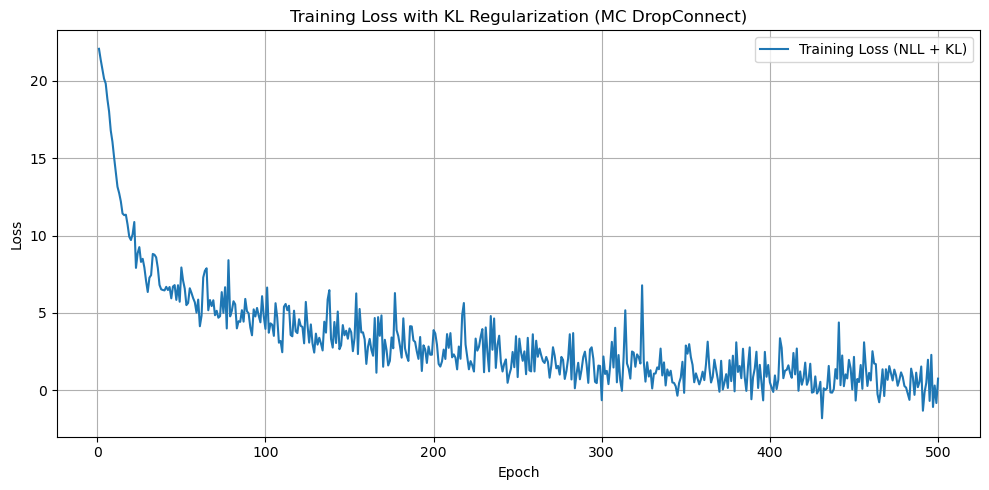

In [13]:

# --- DropConnect Linear Layer (Bayesian-style: always samples mask) ---
class DropConnectLinear(nn.Module):
    def __init__(self, in_features, out_features, dropconnect_p=0.1):
        super().__init__()
        self.dropconnect_p = dropconnect_p
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5 ** 0.5)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / fan_in ** 0.5
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # Always sample a new DropConnect mask
        mask = (torch.rand_like(self.weight) > self.dropconnect_p).float()
        weight = self.weight * mask
        return F.linear(x, weight, self.bias)

# --- Multi-Output Bayesian Regression Model Using DropConnect ---
class MultiOutputDropConnect(nn.Module):
    def __init__(self, input_size, n_hidden=32, dropconnect_p=0.1):
        super().__init__()
        self.fc1 = DropConnectLinear(input_size, n_hidden, dropconnect_p)
        self.fc2 = DropConnectLinear(n_hidden, n_hidden, dropconnect_p)
        self.fc_mean = DropConnectLinear(n_hidden, 2, dropconnect_p)
        self.fc_cov = DropConnectLinear(n_hidden, 3, dropconnect_p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        cov_params = self.fc_cov(x)

        log_var = cov_params[:, :2]
        rho = 0.99 * torch.tanh(cov_params[:, 2])  # Keep correlation in (-0.99, 0.99)
        std = torch.exp(0.5 * log_var)             # Convert log-variance to std
        cov12 = rho * std[:, 0] * std[:, 1]

        cov = torch.zeros(x.size(0), 2, 2, device=x.device)
        cov[:, 0, 0] = std[:, 0]**2
        cov[:, 1, 1] = std[:, 1]**2
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12

        return mean, cov
    

# ==== 2. Loss Function ====

def multi_output_nll(mean, cov_matrix, y_true):
    eps = 1e-3
    eye = torch.eye(2, device=cov_matrix.device).unsqueeze(0)
    cov_pd = cov_matrix + eps * eye
    dist = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov_pd)
    return -dist.log_prob(y_true).mean()

import matplotlib.pyplot as plt

def train(model, optimizer, train_loader, device, epochs=500, lambda_reg=1e-4):
    model.train()
    loss_history = []

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            mean, cov = model(xb)
            nll = multi_output_nll(mean, cov, yb)

            # L2 regularization term (approximates KL)
            l2_reg = sum((param ** 2).sum() for param in model.parameters())
            loss = nll + lambda_reg * l2_reg

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss_history.append(total_loss)

        if epoch % 100 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss:.4f}")

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_history, label='Training Loss (NLL + KL)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss with KL Regularization (MC DropConnect)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MultiOutputDropConnect(input_size=X_train.shape[1], n_hidden=32, dropconnect_p=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train(model, optimizer, train_loader, device, epochs=500)

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm

# Monte Carlo DropConnect inference: forward pass with DropConnect always ON
def mc_predict_with_uncertainty_dropconnect(model, X, n_samples, device):
    model.train()  # Ensure DropConnect stays active
    X = X.to(device)
    all_means, all_covs = [], []
    with torch.no_grad():
        for _ in range(n_samples):
            mean, cov = model(X)
            all_means.append(mean.cpu().numpy())
            all_covs.append(cov.cpu().numpy())
    return np.stack(all_means), np.stack(all_covs)

# Decompose total uncertainty
def calculate_uncertainties(mc_means, mc_covs):
    epistemic = np.var(mc_means, axis=0)
    aleatoric = np.mean(np.diagonal(mc_covs, axis1=2, axis2=3), axis=0)
    total = epistemic + aleatoric
    return epistemic, aleatoric, total

# Metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Coverage calculation
def calc_interval_picp(y_true, y_pred, total_unc, confidence=0.80):
    z = norm.ppf((1 + confidence) / 2)
    lower = y_pred - z * np.sqrt(total_unc)
    upper = y_pred + z * np.sqrt(total_unc)
    picp = np.mean((y_true >= lower) & (y_true <= upper)) * 100
    return lower, upper, picp

n_mc = 300

train_means, train_covs = mc_predict_with_uncertainty_dropconnect(model, X_train, n_mc, device)
test_means, test_covs = mc_predict_with_uncertainty_dropconnect(model, X_test, n_mc, device)

train_pred = train_means.mean(axis=0)
test_pred = test_means.mean(axis=0)

y_train_np, y_test_np = y_train.cpu().numpy(), y_test.cpu().numpy()

train_epi, train_ale, train_tot = calculate_uncertainties(train_means, train_covs)
test_epi, test_ale, test_tot = calculate_uncertainties(test_means, test_covs)

# Print metrics
for name, pred, y_true, tot_unc, epi, ale in [
    ('Train', train_pred, y_train_np, train_tot, train_epi, train_ale),
    ('Test',  test_pred,  y_test_np,  test_tot,  test_epi,  test_ale)
]:
    print(f"\n{name} Set Metrics:")
    for idx, target_label in enumerate(['Measured voltage', 'Predicted voltage']):
        mae, mse, rmse, r2 = evaluate_model(y_true[:, idx], pred[:, idx])
        _, _, picp = calc_interval_picp(y_true[:, idx], pred[:, idx], tot_unc[:, idx], confidence=0.80)
        print(f"  {target_label}:")
        print(f"    MAE:            {mae:.4f}")
        print(f"    RMSE:           {rmse:.4f}")
        print(f"    R²:             {r2:.4f}")
        print(f"    PICP (80%):     {picp:.2f}%")
        print(f"    Epistemic (μ):  {epi[:, idx].mean():.4f}")
        print(f"    Aleatoric (μ):  {ale[:, idx].mean():.4f}")




Train Set Metrics:
  Measured voltage:
    MAE:            0.0478
    RMSE:           0.0774
    R²:             0.9940
    PICP (80%):     100.00%
    Epistemic (μ):  0.0171
    Aleatoric (μ):  0.0256
  Predicted voltage:
    MAE:            0.3540
    RMSE:           0.4861
    R²:             0.7628
    PICP (80%):     87.92%
    Epistemic (μ):  0.0262
    Aleatoric (μ):  0.2528

Test Set Metrics:
  Measured voltage:
    MAE:            0.0532
    RMSE:           0.0798
    R²:             0.9936
    PICP (80%):     96.25%
    Epistemic (μ):  0.0170
    Aleatoric (μ):  0.0243
  Predicted voltage:
    MAE:            0.4267
    RMSE:           0.5267
    R²:             0.7123
    PICP (80%):     71.25%
    Epistemic (μ):  0.0281
    Aleatoric (μ):  0.2499


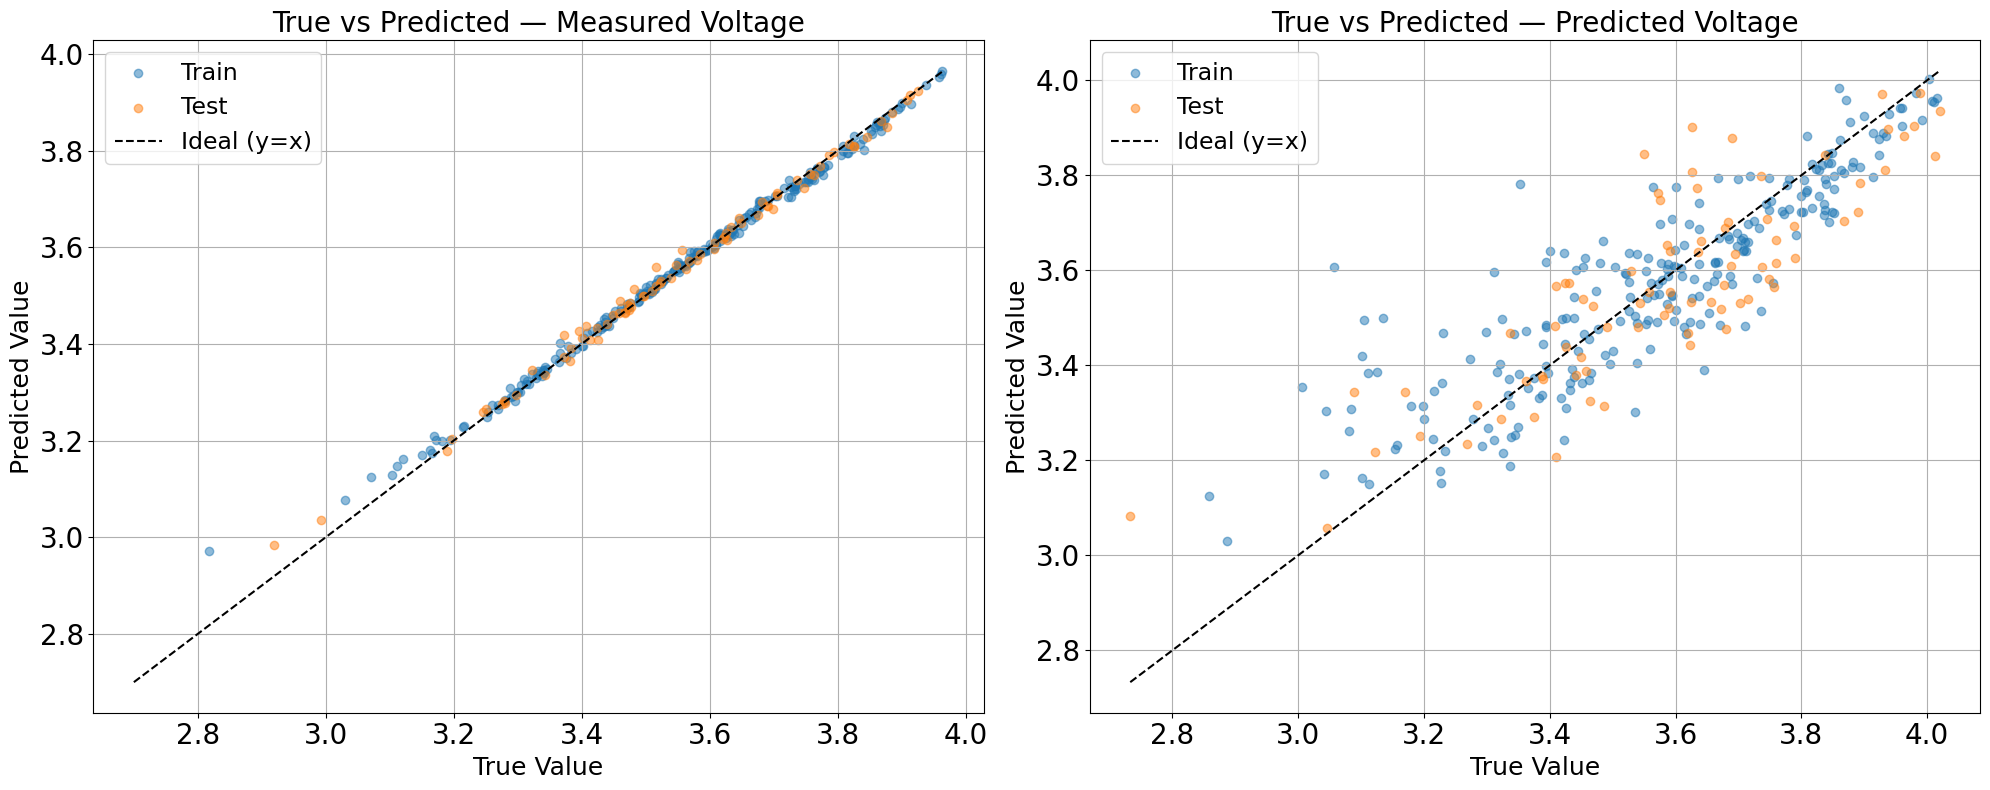

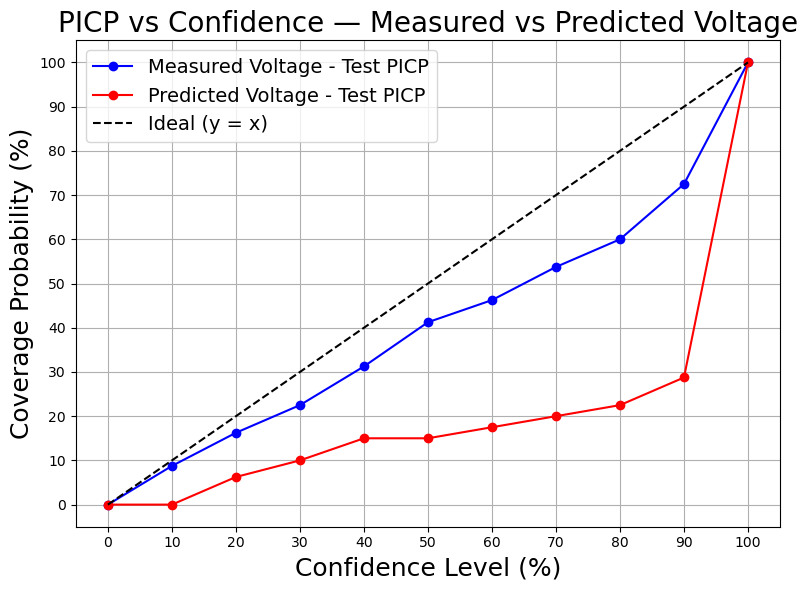

In [15]:
# -------------------------------
# 8. De-normalization and Scatter Plot
# -------------------------------

def de_normalize(data, mean, std):
    mean_np = mean.cpu().numpy() if isinstance(mean, torch.Tensor) else mean
    std_np  = std.cpu().numpy()  if isinstance(std, torch.Tensor) else std
    return data * std_np + mean_np

# Denormalize predictions + ground truth
train_preds_denorm = de_normalize(train_pred, mean_y, std_y)
test_preds_denorm  = de_normalize(test_pred,  mean_y, std_y)
y_train_denorm     = de_normalize(y_train.cpu().numpy(), mean_y, std_y)
y_test_denorm      = de_normalize(y_test.cpu().numpy(),  mean_y, std_y)
num_samples = len(y_train) + len(y_test) + len(y_recal)

# Plot true vs predicted
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
target_names = ['Measured Voltage', 'Predicted Voltage']

# De-normalize total predictive variance
std_y_np = std_y.cpu().numpy()
train_tot = train_tot * (std_y_np ** 2)
test_tot  = test_tot  * (std_y_np ** 2)

for i, target_name in enumerate(target_names):
    ax = axes[i]
    ax.scatter(y_train_denorm[:, i], train_preds_denorm[:, i], alpha=0.5, label='Train')
    ax.scatter(y_test_denorm[:, i],  test_preds_denorm[:, i],  alpha=0.5, label='Test')

    # Diagonal line
    start = 2.7 if i == 0 else min(y_train_denorm[:, i].min(), y_test_denorm[:, i].min())
    end   = max(y_train_denorm[:, i].max(), train_preds_denorm[:, i].max(),
                y_test_denorm[:, i].max(), test_preds_denorm[:, i].max())
    ax.plot([start, end], [start, end], '--', color='black', label='Ideal (y=x)')

    # **Double-sized text**
    ax.set_xlabel('True Value',      fontsize=18)   # was ~12 → now ~24
    ax.set_ylabel('Predicted Value', fontsize=18)
    ax.set_title(
        f'True vs Predicted — {target_name}', #({num_samples} samples)',
        fontsize=20  # was ~16 → now ~32
    )
    ax.legend(fontsize=12+5)              # was ~12 → now ~24
    ax.tick_params(axis='both', labelsize=10*2)  # was ~10 → now ~20
    ax.grid(True)

plt.tight_layout()
plt.show()
# -------------------------------
# 9. PICP Plotting over Confidence Levels
# -------------------------------

confidence_levels = np.linspace(0, 1, 11)
train_picps = {1: [], 2: []}
test_picps  = {1: [], 2: []}

# Compute PICP for each confidence level
for cl in confidence_levels:
    for idx in range(2):
        _, _, picp_train = calc_interval_picp(y_train.cpu().numpy()[:, idx], train_pred[:, idx], train_tot[:, idx], cl)
        _, _, picp_test  = calc_interval_picp(y_test.cpu().numpy()[:, idx],  test_pred[:, idx],  test_tot[:, idx],  cl)

        train_picps[idx + 1].append(picp_train)
        test_picps[idx + 1].append(picp_test)

# Plot PICP vs Confidence for both Predicted and Measured Voltage
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PICP for Test set for both Predicted and Measured Voltage (target_names[0] = Measured Voltage, target_names[1] = Predicted Voltage)
ax.plot(confidence_levels * 100, test_picps[1], marker='o', label=f'Measured Voltage - Test PICP', linestyle='-', color='blue')
ax.plot(confidence_levels * 100, test_picps[2], marker='o', label=f'Predicted Voltage - Test PICP', linestyle='-', color='red')

# Plot Ideal line (y = x) for reference
ax.plot([0, 100], [0, 100], linestyle='--', label='Ideal (y = x)', color='black')

# Set plot labels and title
ax.set_xlabel('Confidence Level (%)', fontsize=18)
ax.set_ylabel('Coverage Probability (%)', fontsize=18)
ax.set_title('PICP vs Confidence — Measured vs Predicted Voltage', fontsize=20)

# Set ticks and grid
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 11))
ax.grid(True)

# Add legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()




Optimal λ (calibration scale): 0.7309


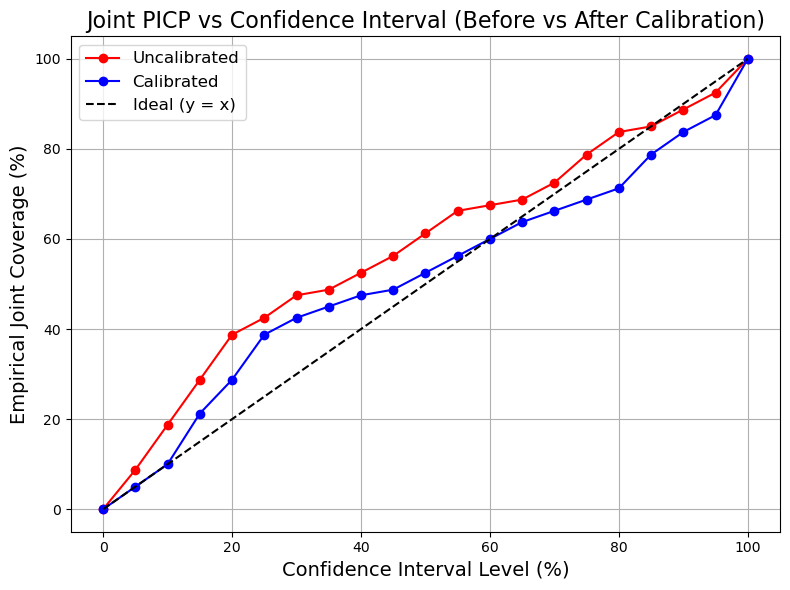

Joint ECE before calibration:  0.0786
Joint ECE after  calibration:  0.0506


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize_scalar

# ---- Step 1: Core Functions ----

def compute_joint_picp_curve(y_true, pred_mean, cov_matrices, levels=np.linspace(0.0, 1.0, 21)):
    N, D = y_true.shape
    empirical_coverages = []
    diffs = y_true - pred_mean

    for alpha in levels:
        threshold = chi2.ppf(alpha, df=D) if alpha < 1.0 else np.inf
        mahalanobis_sq = np.array([
            d @ np.linalg.inv(cov + 1e-3 * np.eye(D)) @ d
            for d, cov in zip(diffs, cov_matrices)
        ])
        coverage = np.mean(mahalanobis_sq <= threshold)
        empirical_coverages.append(coverage)

    return levels, np.array(empirical_coverages)

def compute_joint_ece(levels, empirical_coverages):
    return np.mean(np.abs(empirical_coverages - levels))

def plot_joint_picp(levels, coverages, label, color):
    plt.plot(levels * 100, coverages * 100, 'o-', label=label, color=color)

def calibrate_multivariate_covariance_scale(y_true, mc_means, mc_covs, confidence_levels=np.linspace(0.0, 1.0, 21)):
    def objective(scale):
        scaled_covs = mc_covs * scale
        _, picp = compute_joint_picp_curve(y_true, mc_means.mean(axis=0), scaled_covs.mean(axis=0), confidence_levels)
        return np.mean(np.abs(picp - confidence_levels))  # ECE

    result = minimize_scalar(objective, bounds=(0.1, 10.0), method='bounded')
    return result.x

# ---- Step 2: Calibrate λ using test set ----

lambda_opt = calibrate_multivariate_covariance_scale(
    y_true=y_test_np,
    mc_means=test_means,
    mc_covs=test_covs
)
print(f"\nOptimal λ (calibration scale): {lambda_opt:.4f}")

# ---- Step 3: Compute Joint PICP Curves ----

# Uncalibrated
levels, joint_picp_uncal = compute_joint_picp_curve(
    y_true=y_test_np,
    pred_mean=test_means.mean(axis=0),
    cov_matrices=test_covs.mean(axis=0)
)
ece_uncal = compute_joint_ece(levels, joint_picp_uncal)

# Calibrated
scaled_test_covs = test_covs * lambda_opt
_, joint_picp_cal = compute_joint_picp_curve(
    y_true=y_test_np,
    pred_mean=test_means.mean(axis=0),
    cov_matrices=scaled_test_covs.mean(axis=0)
)
ece_cal = compute_joint_ece(levels, joint_picp_cal)

# ---- Step 4: Plot Before vs After Calibration ----

plt.figure(figsize=(8, 6))
plot_joint_picp(levels, joint_picp_uncal, label="Uncalibrated", color="red")
plot_joint_picp(levels, joint_picp_cal, label="Calibrated", color="blue")
plt.plot([0, 100], [0, 100], 'k--', label='Ideal (y = x)')
plt.xlabel("Confidence Interval Level (%)", fontsize=14)
plt.ylabel("Empirical Joint Coverage (%)", fontsize=14)
plt.title("Joint PICP vs Confidence Interval (Before vs After Calibration)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Step 5: Report Metrics ----

print(f"Joint ECE before calibration:  {ece_uncal:.4f}")
print(f"Joint ECE after  calibration:  {ece_cal:.4f}")
